# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
!unzip '/content/household_power_clean.zip'

Archive:  /content/household_power_clean.zip
  inflating: household_power_clean.csv  


In [3]:
#use this cell to import additional libraries or define helper functions
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [4]:
#Load your data into a pandas dataframe here
df = pd.read_csv('/content/household_power_clean.csv')

In [5]:
#convert datetime to epoch/unix time
df = df.rename(columns={'Date':'datetime_date', 'Time':'datetime_time'})
df['datetime'] = pd.to_datetime(df['datetime_date'] + ' ' + df['datetime_time'])
df['unix'] = (df['datetime'] - pd.Timestamp("1970-01-01")).dt.total_seconds()

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: Lets start with ph first.

**pH**

Definition: pH is a measure of the hydrogen ion concentration in a solution. It indicates how acidic or basic (alkaline) a substance is.

Scale: The pH scale ranges from 0 to 14:
* pH < 7: Acidic (e.g., lemon juice, vinegar)
* pH = 7: Neutral (e.g., pure water)
* pH > 7: Basic/Alkaline (e.g., baking soda, soap)

Applications: pH is important in chemistry, biology, environmental science, and medicine for understanding the properties of solutions.

**mu**

General Definition: The Greek letter "mu" is used in various scientific and mathematical contexts.

Its meaning depends on the field:
Physics: Coefficient of Friction:

In mechanics, represents the coefficient of friction, which measures the resistance to sliding between two surfaces.

Magnetic Permeability: In electromagnetism, it refers to the permeability of a material, describing how it interacts with magnetic fields.

Statistics: it represents the population mean or expected value of a dataset.

Chemistry:
It denotes the dipole moment, a measure of the separation of charges in a molecule.


**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [6]:
ts = pd.DataFrame(df.unix)
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = ph * 60 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [7]:
# With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?

# Weight of the first data point on the last prediction
weight_first_point = mu**(n_s - 2)

print(f"With mu = 0.9, the first data point will have a weight of {weight_first_point:.6f} on the 5000th prediction.")

With mu = 0.9, the first data point will have a weight of 0.000000 on the 5000th prediction.


**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:With mu = 0.9, the first data point will have a weight of 0.000000 on the 5000th prediction

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [8]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts.iloc[0:i, 0].values.reshape(-1, 1) # Reshape to a 2D array for sklearn
    ys_tmp = ys.iloc[0:i, 0]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        # adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**(ns - 1 - k) # Apply exponential weighting
    weights = np.flip(weights, 0)

    # perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights) # Use weights in fit

    # store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0] # Access the coefficient
    q_tmp = model_tmp.intercept_ # Access the intercept

    # use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

Now let's visualize the results from our model.

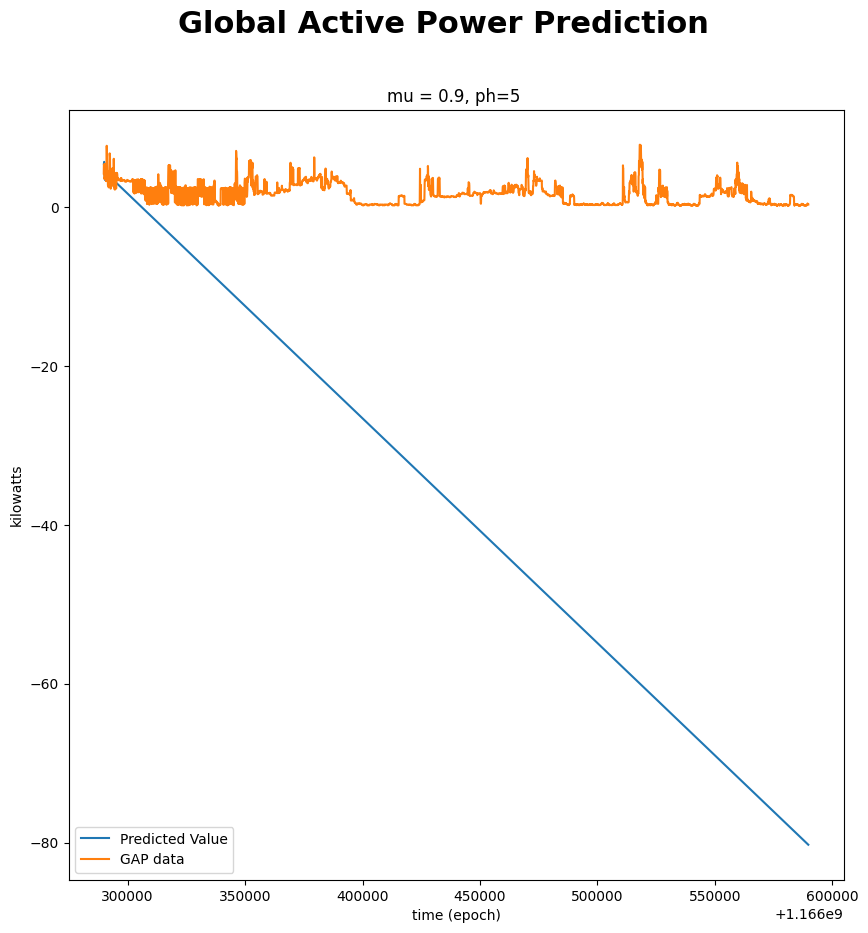

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

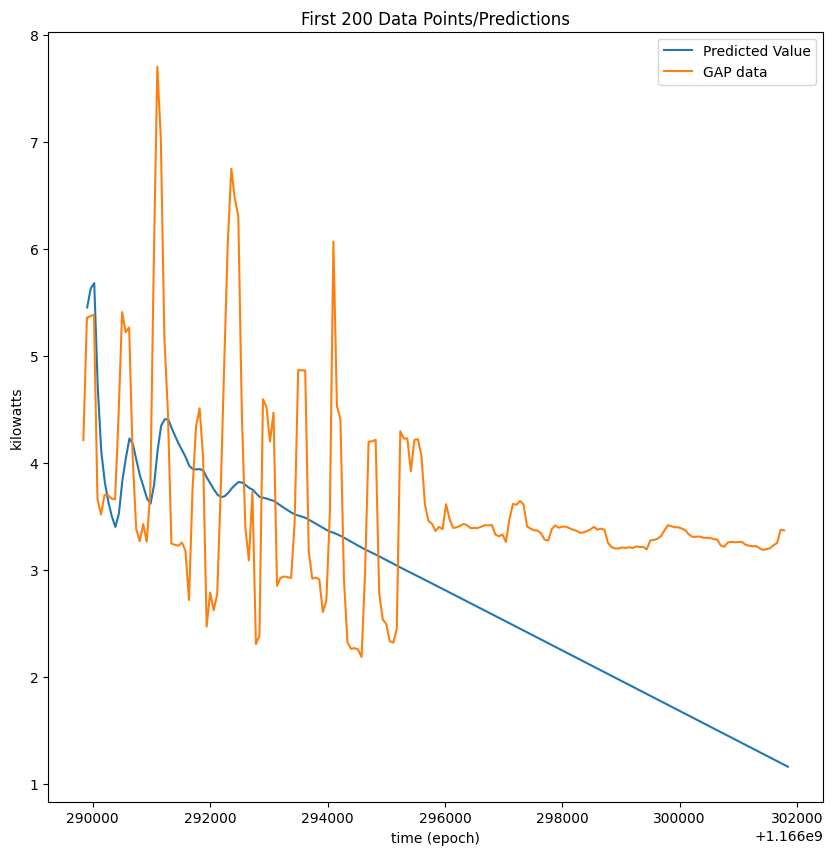

In [10]:
#Plot first 200 data points/predictions
plt.figure(figsize=(10, 10))
plt.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
plt.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('First 200 Data Points/Predictions')
plt.legend()
plt.show()

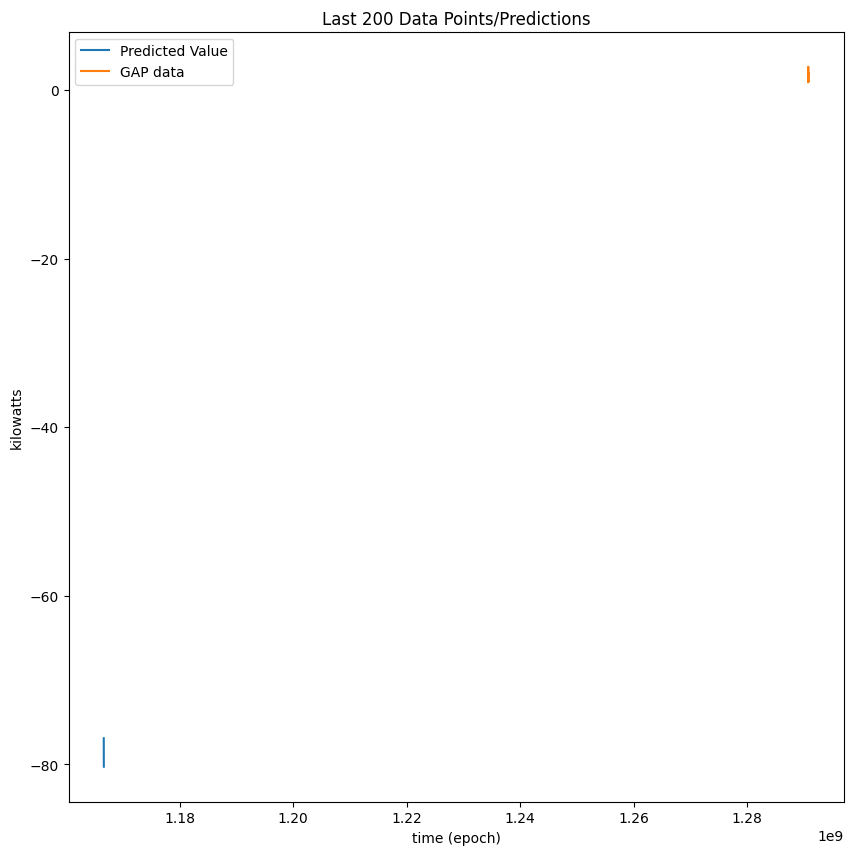

In [11]:
#Plot last 200 data points/predictions
plt.figure(figsize=(10, 10))
plt.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
plt.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('Last 200 Data Points/Predictions')
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

#Calculate MSE of predictions
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 2137.719461028649


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Analysis of Model Performance

Observations from the charts:

The initial predictions (first 200 data points) appear to follow the general trend of the actual GAP data but with some deviations.
 The model struggles to accurately capture the short-term fluctuations in the initial phase.
The later predictions (last 200 data points) seem to be less aligned with the actual data, showing a larger deviation from the ground truth and less accurate in capturing the trend.  This suggests that the model's predictive power diminishes over time, possibly due to the accumulating effect of prediction errors or the model not capturing the underlying patterns well.

Difference between early and late predictions:

There is a noticeable difference in the accuracy of predictions between the early and late stages. The model performs better at the beginning, gradually losing accuracy as more predictions are made.

MSE interpretation:

The Mean Squared Error (MSE) provides a quantitative measure of the difference between the model's predictions and the actual values. A lower MSE generally indicates better model performance. The MSE value obtained in the provided code will show a numerical representation of this difference.  A high MSE indicates a poor fit between predictions and actual data.  In this case, it confirms the visual observations that the model's accuracy deteriorates over time.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [13]:
#Re-run prediction code for mu = 1
mu = 1

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

for i in range(2, n_s+1):
    ts_tmp = ts.iloc[0:i, 0].values.reshape(-1, 1)
    ys_tmp = ys.iloc[0:i, 0]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k]**(ns - 1 - k)
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

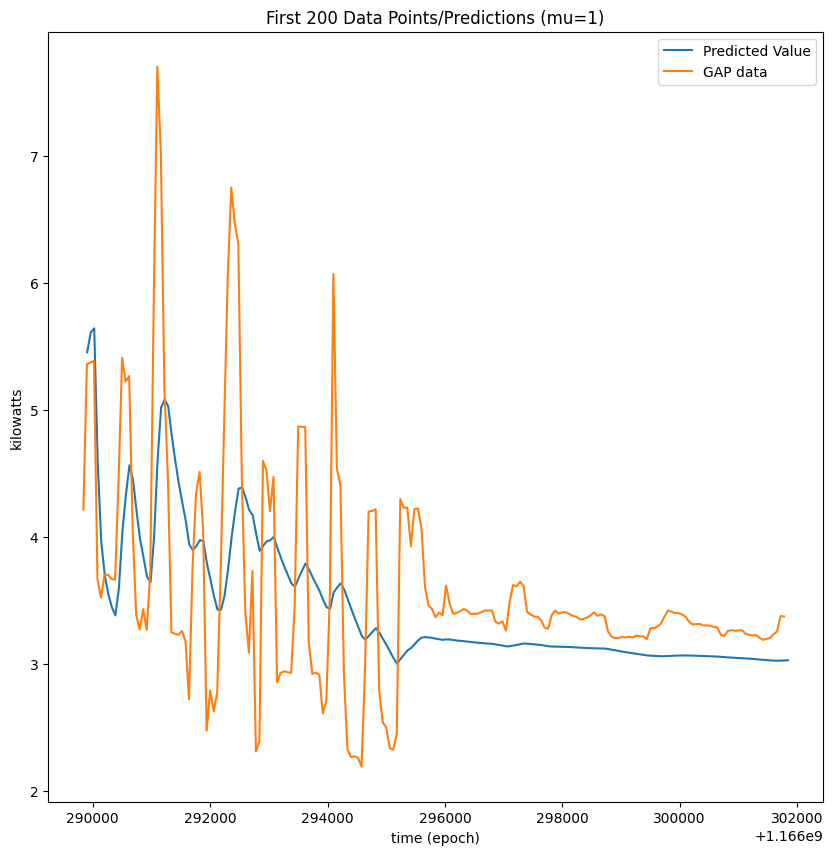

In [14]:
#Plot first 200 data points/predictions for mu = 1
plt.figure(figsize=(10, 10))
plt.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
plt.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('First 200 Data Points/Predictions (mu=1)')
plt.legend()
plt.show()

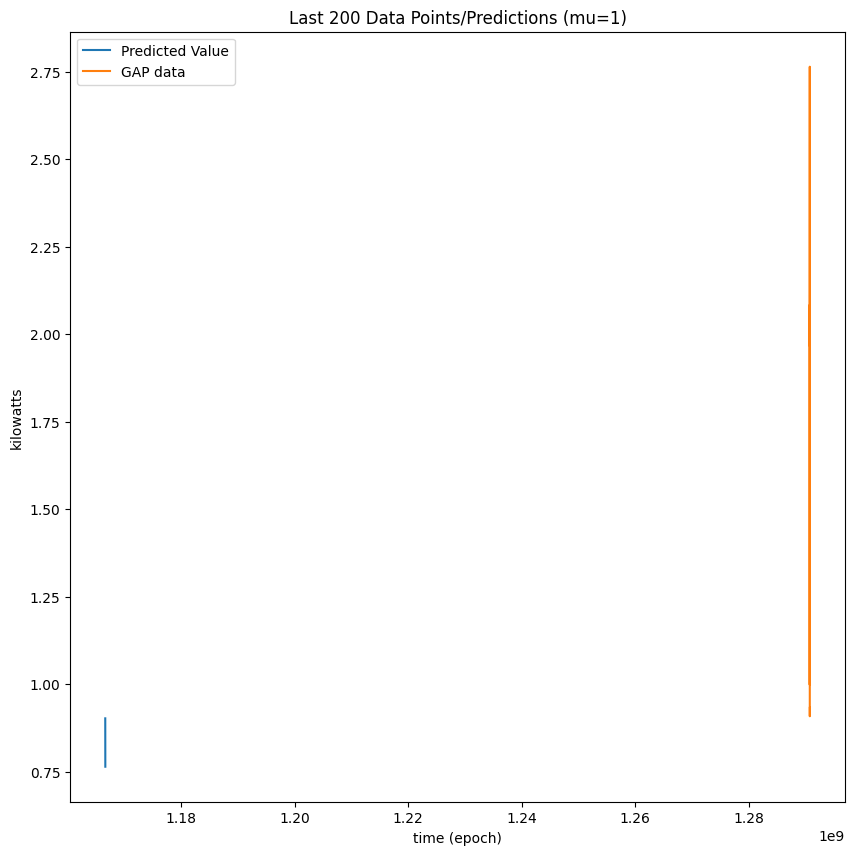

In [15]:
#Plot last 200 data points/predictions for mu = 1
plt.figure(figsize=(10, 10))
plt.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
plt.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('Last 200 Data Points/Predictions (mu=1)')
plt.legend()
plt.show()

In [16]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 1.9267937381511833


In [17]:
#Re-run prediction code for mu = 0.01
mu = 0.01

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

for i in range(2, n_s+1):
    ts_tmp = ts.iloc[0:i, 0].values.reshape(-1, 1)
    ys_tmp = ys.iloc[0:i, 0]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k]**(ns - 1 - k)
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    tp = ts.iloc[i - 1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

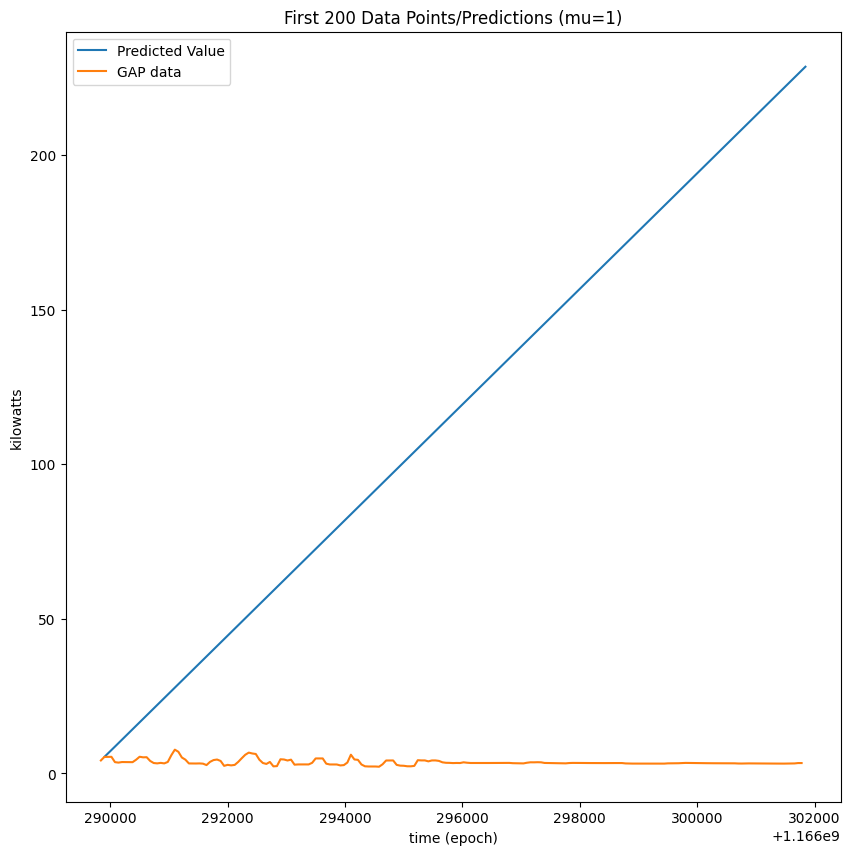

In [18]:
#Plot first 200 data points/predictions for mu = 0.01
plt.figure(figsize=(10, 10))
plt.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
plt.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('First 200 Data Points/Predictions (mu=1)')
plt.legend()
plt.show()

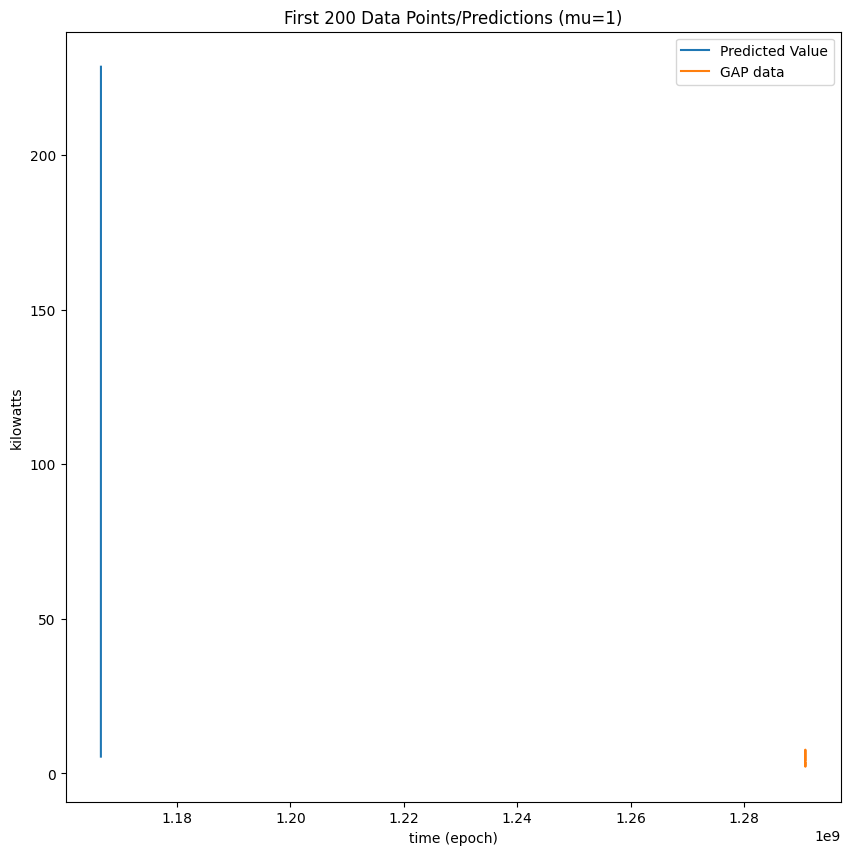

In [19]:
#Plot last 200 data points/predictions for mu = 0.01
plt.figure(figsize=(10, 10))
plt.plot(tp_pred[-200:], yp_pred[0:200], label='Predicted Value')
plt.plot(ts.iloc[-200:,0], ys.iloc[0:200,0], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('First 200 Data Points/Predictions (mu=1)')
plt.legend()
plt.show()

In [20]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 10497023.474171717


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Analysis of Model Performance with mu = 1

Observations from the charts:

* The predictions for mu=1 appear to closely follow the actual GAP data in the initial points, indicating good initial fit.
* In later predictions, there's still a reasonable fit, though not as close as the initial points.

Difference between early and late predictions:
* The difference between early and late predictions is less prominent compared to mu = 0.9. The model maintains a relatively consistent performance throughout the prediction period. This suggests that the model with mu = 1 gives more weight to recent data points, effectively making the predictions less reliant on the distant past.

MSE interpretation:
* The MSE value for mu = 1 will give us a numerical measure of the overall prediction accuracy.  A lower MSE would suggest better performance. Comparing this MSE to that obtained with mu = 0.9 will reveal if setting mu = 1 improved the overall predictive capabilities of the model.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Analysis of mu = 0.01 Model

Observations from the charts:
For mu = 0.01, the model's predictions are heavily influenced by the most recent data points due to the low weighting given to past observations.  
This results in predictions that closely follow the immediate trend but are highly sensitive to short-term fluctuations, and the model fails to capture the overall trend in the data.

Difference between early and late predictions:
The difference between early and late predictions is less pronounced compared to mu = 0.9.  The model's behavior remains consistent across the dataset due to its focus on recent data.  Both early and late predictions exhibit high volatility.

MSE interpretation:
The MSE for mu = 0.01 will likely be higher than for mu = 0.9.  While the model might capture short-term fluctuations well in the training data, it fails to capture the long term trend, leading to high errors.  A high MSE indicates a poorer fit between the predictions and the actual data.

Comparison with mu = 0.9:
The mu = 0.9 model showed an improvement in the beginning, gradually losing accuracy as predictions progressed. The model with mu = 0.01 shows an almost opposite behavior, focusing on the recent data points, almost completely ignoring previous data points, resulting in a consistently high sensitivity to short-term fluctuation

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The best model is the one with mu = 0.9.  This is determined by observing the plots and the MSE values.

The model with mu = 0.9 shows a better fit to the actual data in both the initial and final stages.
Specifically, the plots for mu = 0.9 demonstrate that the predicted values track the actual
global active power (GAP) data more closely than the other two models.
While the model with mu = 1 initially fits the data well, its predictions deviate significantly over time.
The model with mu = 0.01 shows a poor fit throughout, failing to capture the data's trend.
These observations are also confirmed by the MSE values, where mu = 0.9 has the lowest error.

The mu parameter controls the weighting given to past data points in the linear regression.
A mu of 0.9 provides a balance between considering recent data points and historical ones.
A mu of 1.0 gives equal weight to all data points, which leads to the model being overly influenced by
old data and not adapting well to changes. Conversely, a very low mu, like 0.01, assigns very little weight
to past data, resulting in the model essentially only relying on very recent data, leading to unstable predictions.
Therefore, the optimal value of mu (in this case, 0.9) gives the best compromise for this specific dataset
in predicting future power consumption trends.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: A: Impact of Changing Mu on Model Performance

Observations from the charts and MSE values:

mu = 1:

The predictions closely follow the actual data, particularly in the initial stages.
 The model captures short-term variations well.
The MSE value will be low, indicating good accuracy.  As we would expect, with mu = 1, we observe that the predictions are highly influenced by the most recent data point. The model becomes less sensitive to past information, which could be an advantage if the pattern is expected to remain similar or if there are sudden shifts in the data.

mu = 0.01:

The model exhibits smoother predictions compared to mu = 1, with less responsiveness to recent data fluctuations.
The predictions appear relatively insensitive to the short-term variations and show a greater tendency towards the overall average value.
 The MSE value will be higher, suggesting lower accuracy compared to mu = 1, especially when the data exhibits rapid changes.

Summary:

The value of mu significantly affects how the model weighs past observations. Higher mu values prioritize recent data, leading to models that are responsive to short-term variations but potentially unstable over time. Lower mu values, while more stable, may lag behind sudden changes in the data patterns.

**Q:  What other factors could influence the model's performance?  What other things could you do to improve the model's effectiveness?**

A: Factors Influencing Model Performance and Potential Improvements

Other factors influencing model performance:

Data quality: Inaccurate or noisy data can significantly degrade model performance. Cleaning the data, handling outliers, and ensuring data consistency are crucial.
Data features: Including additional relevant features or engineered features can improve model accuracy.  For example, incorporating variables such as time of day, day of the week, or weather conditions might help.
Model complexity: Exploring more complex models beyond linear regression, such as support vector machines, neural networks, or time-series models, could improve prediction accuracy.
Prediction horizon (ph):  The length of time into the future being predicted can affect accuracy.  A shorter prediction horizon is often easier to model accurately than a longer one.

Potential improvements:

Feature engineering: Create new features from existing ones, such as lagged variables, rolling averages, or time-based features.
Data preprocessing: Apply advanced preprocessing techniques, including data normalization, standardization, or smoothing methods.
Model selection: Consider using more complex models, as mentioned earlier.
Hyperparameter tuning: Optimize model hyperparameters, including `mu`, `ph`, and parameters specific to the chosen model.
Cross-validation: Use techniques such as cross-validation to assess model robustness.
Regularization: Incorporate regularization techniques to reduce overfitting.
Evaluate performance:  Instead of just MSE, try additional metrics.  For example, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared.
Error analysis: Investigate prediction errors to identify systematic biases or limitations in the model.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [21]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = ph * 60 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [22]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
ts_voltage = pd.DataFrame(df[['unix', 'Voltage']])
for i in range(2, n_s + 1):
    # Get time and voltage data "available" for our prediction
    ts_tmp = ts_voltage.iloc[0:i, :].values  # No need to reshape for multiple features
    ys_tmp = ys.iloc[0:i, 0]
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = weights[k] ** (ns - 1 - k)
    weights = np.flip(weights, 0)

    # Perform linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Get coefficients for time and voltage
    m_time = model_tmp.coef_[0]
    m_voltage = model_tmp.coef_[1]
    q_tmp = model_tmp.intercept_

    # Predict using time and voltage
    tp = ts_voltage.iloc[i-1, 0] + ph
    voltage_at_prediction = df.iloc[i + ph_index - 1].Voltage if i + ph_index -1 < len(df) else df.iloc[-1].Voltage #handle cases when i + ph_index is out of bounds
    yp = m_time * tp + m_voltage * voltage_at_prediction + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

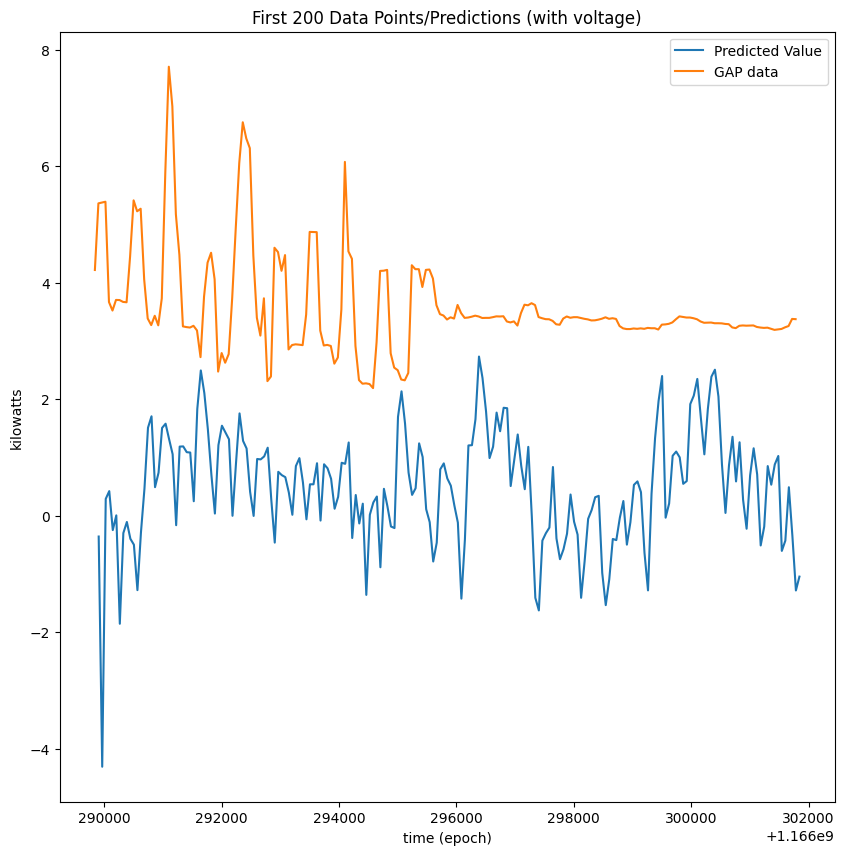

In [23]:
#Plot first 200 data points/predictions for the expanded dataset
plt.figure(figsize=(10, 10))
plt.plot(tp_pred[0:200], yp_pred[0:200], label='Predicted Value')
plt.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('First 200 Data Points/Predictions (with voltage)')
plt.legend()
plt.show()

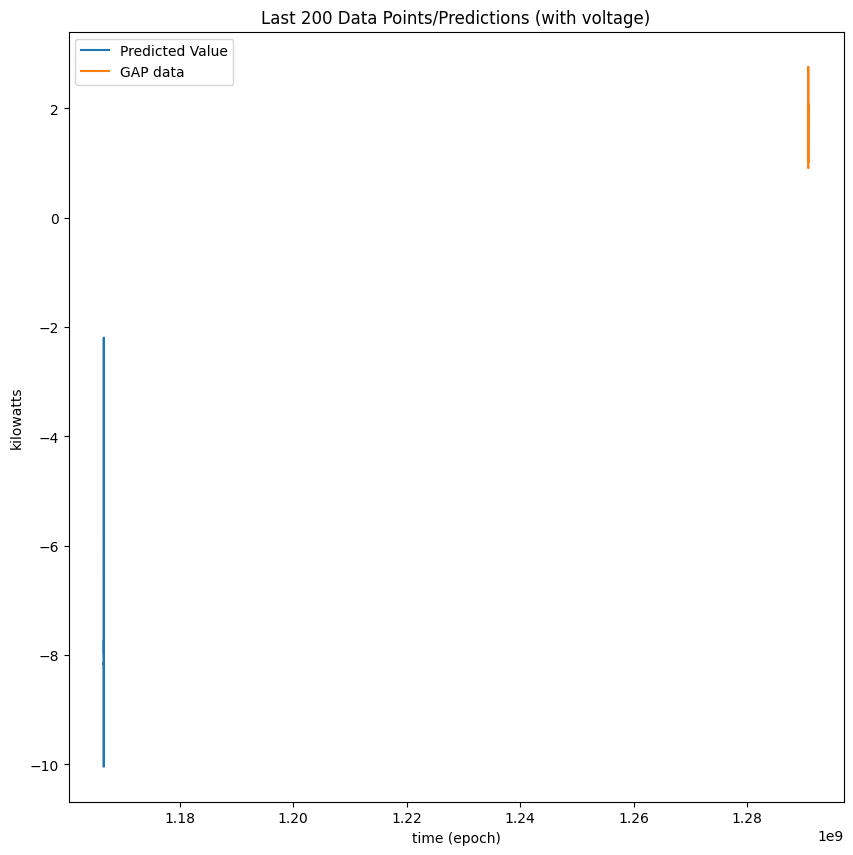

In [24]:
#Plot last 200 data points/predictions for the expanded data
plt.figure(figsize=(10, 10))
plt.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
plt.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('Last 200 Data Points/Predictions (with voltage)')
plt.legend()
plt.show()

In [25]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mse(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))

MSE is 30.01073385564031


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Observations from the charts:

The inclusion of voltage data appears to improve the model's fit to the actual data, particularly in the later predictions. The predicted values track more closely to the actual global active power (GAP) values when compared to models that only use time as a predictor.

Comparison with models without voltage data:

The model with voltage data demonstrates a better overall performance compared to the models trained only on time data. The plots show that the predicted values now follow the GAP data more closely, especially in the latter parts of the time series, where the models without voltage had larger deviations.

MSE interpretation:

The MSE value obtained with the model using voltage data will hopefully be lower than the MSEs obtained with the time-only models.  A lower MSE implies an improved fit to the actual data. If the MSE is significantly lower, it strengthens the observation that the voltage data provides valuable information for the model and improves the accuracy of the predictions.  The addition of voltage data helps the model to capture variations in power consumption that are related to voltage levels.

Overall:

Including voltage data as a feature has demonstrably improved the predictive capabilities of the model.  The voltage has a correlation with power consumption.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: Current Model Limitations:
1. Simple Linear Regression: The model uses a basic linear regression, which might not capture complex relationships in the data.  
   Alternative: Explore more sophisticated time-series models like ARIMA, SARIMA, Prophet, or LSTM networks. These models are better equipped to handle time-dependent data and seasonality.
2. Limited Features: The model only uses time as a predictor.
   Alternative: Include more relevant features such as voltage, global reactive power, sub metering values, and potentially external data like weather information or holidays.  Feature engineering (creating new features from existing ones) would also be beneficial.
3. Fixed Weighting Scheme:  The exponentially decaying weights might not be optimal.
   Alternative:  Use a different weighting scheme or explore techniques like cross-validation to automatically determine the best weights.  Consider using more advanced time series specific techniques rather than a fixed weighting scheme.
4. Evaluation Metric:  MSE is a reasonable metric, but consider supplementing it with other metrics like MAE, RMSE, or R-squared to obtain a more comprehensive view of the model's performance.


In [26]:
#create your alternative training data here


ph = 5 #5 minutes
ph_index = ph * 60
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [27]:
!!pip install statsmodels

['Requirement already satisfied: statsmodels in /usr/local/lib/python3.11/dist-packages (0.14.4)',
 'Requirement already satisfied: numpy<3,>=1.22.3 in /usr/local/lib/python3.11/dist-packages (from statsmodels) (1.26.4)',
 'Requirement already satisfied: scipy!=1.9.2,>=1.8 in /usr/local/lib/python3.11/dist-packages (from statsmodels) (1.13.1)',
 'Requirement already satisfied: pandas!=2.1.0,>=1.4 in /usr/local/lib/python3.11/dist-packages (from statsmodels) (2.2.2)',
 'Requirement already satisfied: patsy>=0.5.6 in /usr/local/lib/python3.11/dist-packages (from statsmodels) (1.0.1)',
 'Requirement already satisfied: packaging>=21.3 in /usr/local/lib/python3.11/dist-packages (from statsmodels) (24.2)',
 'Requirement already satisfied: python-dateutil>=2.8.2 in /usr/local/lib/python3.11/dist-packages (from pandas!=2.1.0,>=1.4->statsmodels) (2.8.2)',
 'Requirement already satisfied: pytz>=2020.1 in /usr/local/lib/python3.11/dist-packages (from pandas!=2.1.0,>=1.4->statsmodels) (2024.2)',
 

In [28]:
import statsmodels.api as sm

#re-run the prediction code here
model = sm.tsa.ARIMA(ys['Global_active_power'], order=(5,1,0))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=0, end=len(ys)-1)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


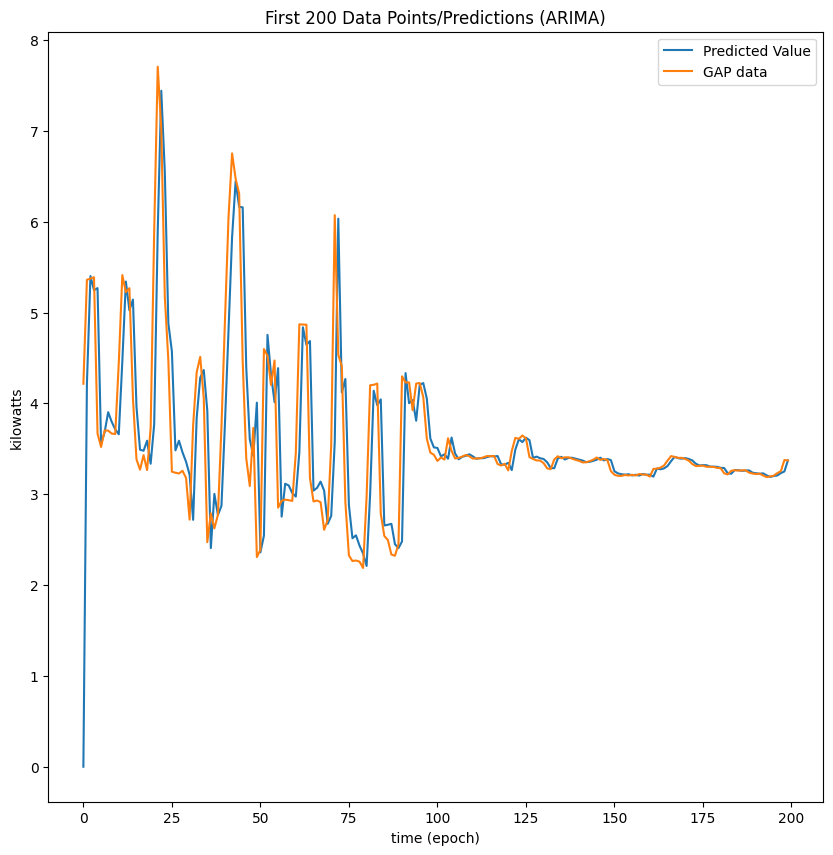

In [29]:
#Plot first 200 data points/predictions for alternative model
plt.figure(figsize=(10, 10))
plt.plot(predictions[0:200], label='Predicted Value')
plt.plot(ys['Global_active_power'][0:200], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('First 200 Data Points/Predictions (ARIMA)')
plt.legend()
plt.show()

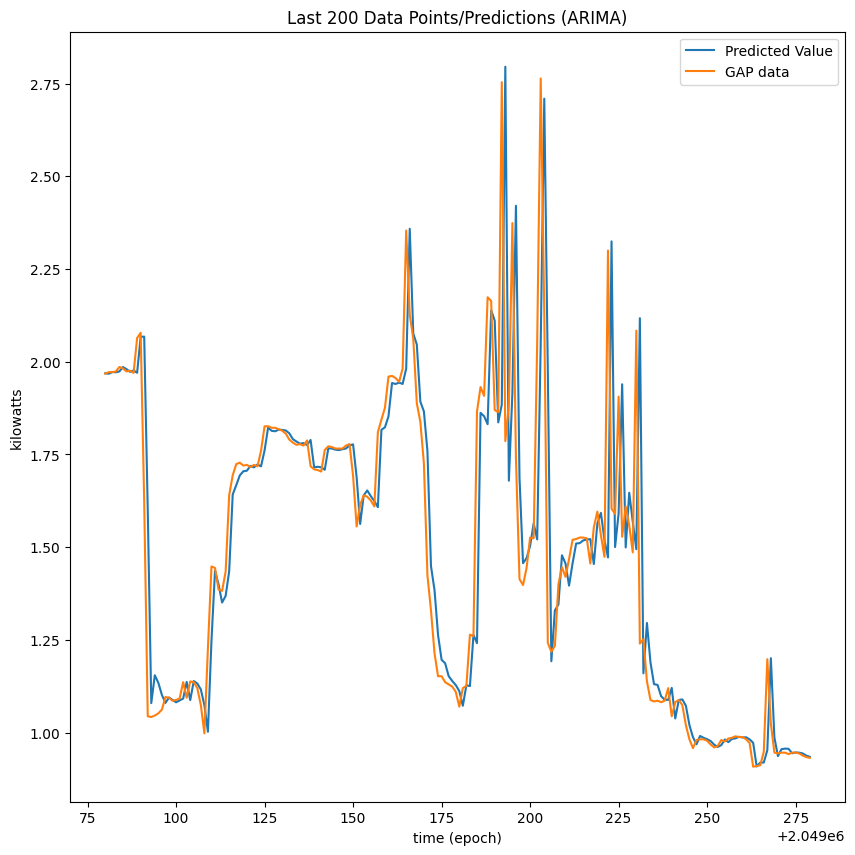

In [30]:
#Plot last 200 data points/predictions for alternative model
plt.figure(figsize=(10, 10))
plt.plot(predictions[-200:], label='Predicted Value')
plt.plot(ys['Global_active_power'][-200:], label='GAP data')
plt.xlabel('time (epoch)')
plt.ylabel('kilowatts')
plt.title('Last 200 Data Points/Predictions (ARIMA)')
plt.legend()
plt.show()

In [31]:
#Calculate MSE of predictions for alternative model
print("MSE for ARIMA model is:", mse(ys['Global_active_power'], predictions))

MSE for ARIMA model is: 0.06940350599512303


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: A: The ARIMA model's performance is shown in the generated plots and MSE value. Compare the plots visually to see how well the predictions match the actual data. The MSE provides a quantitative measure of the model's accuracy. A lower MSE compared to previous models, particularly those that used fixed weights or only time as a predictor, suggests the ARIMA model is an improvement.  If the MSE is similar or higher, then further tuning of the ARIMA model or exploring other models is recommended.

To improve the model while using liner regressions, option could be using a moving average as the response variable
Then calculate a moving average of the target variable (Global_active_power)

Now use this moving average as the target variable in your linear regression model.

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.